## Import Data, clean and look at n-gram length

In [1]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt

# from tensorflow import set_random_seed
# set_random_seed(2)


In [2]:
textWords = []
lineLength =[]
corpusForTokenizerFit =[]
with open('data/phrases_data.txt', 'r') as f:
    for line in f:
        string = line.lower()
        doublespaces = re.compile(" {2,}")
        string = doublespaces.sub('', string)
        p = re.compile("[^a-z0-9 ']")

        string = p.sub('', string)
        corpusForTokenizerFit.append(string)
        lineList = string.split(" ")
        # print(string)
        # print(lineList)
        lineLength.append(len(lineList))

        textWords .append(lineList)
    # line.lower()

In [3]:
print(f' number of examples {len( textWords)}')

 number of examples 10000


In [4]:
#check number of words per sentence to get an idea of reasonable N-gram sizes
print(f'max {max(lineLength)}')
print(f'median {np.quantile(lineLength, 0.5)}')
print(f'90th {np.quantile(lineLength, 0.90)}')

max 68
median 8.0
90th 12.0


Max sequence is 68 but that is way too long, we can use the 90th Percentile N-gram of n=12

Next step is to initialize the tokenizer and look at how large our dictionary is

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpusForTokenizerFit)
word_index = tokenizer.word_index
total_unique_words = len(tokenizer.word_index) + 1 

print(total_unique_words)
# print(word_index.items()[:100])

7299


In [7]:
# save the tokenizer in model directory
import pickle

# saving
with open('model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

The dataset has a pretty diverse word count at 7299 unique tokens.

Next step is to break down the sentences into N-Grams from N=1 to N=12 and pad out the shorter vectors

In [8]:
# created Tokenized NGrams
input_sequences = []
for line in corpusForTokenizerFit:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)): 
        n_gram_seqs = token_list[:i+1]
        input_sequences.append(n_gram_seqs)
print(len(input_sequences))
print(input_sequences[:5])

71135
[[193, 226], [193, 226, 140], [5, 13], [5, 13, 3], [5, 13, 3, 40]]


In [9]:

max_seq_length = 12 # from 90th Percentile
input_seqs = np.array(pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre'))

print(input_seqs[:5])

[[  0   0   0   0   0   0   0   0   0   0 193 226]
 [  0   0   0   0   0   0   0   0   0 193 226 140]
 [  0   0   0   0   0   0   0   0   0   0   5  13]
 [  0   0   0   0   0   0   0   0   0   5  13   3]
 [  0   0   0   0   0   0   0   0   5  13   3  40]]


In [10]:
x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels, num_classes=total_unique_words)
print(x_values[:3])
print(labels[:3])

[[  0   0   0   0   0   0   0   0   0   0 193]
 [  0   0   0   0   0   0   0   0   0 193 226]
 [  0   0   0   0   0   0   0   0   0   0   5]]
[226 140  13]


I will use Glove embeddings to populate an embedding layer with semantic embedding vectors, glove is a decent choice because it does not have embedded information about word position in sentence structure. Capturing context of the position of the next word in the sentence structure will be deal with by our BiLSTM.

In [11]:
# https://nlp.stanford.edu/data/glove.6B.zip
path = "data/glove.6B.100d.txt"

embeddings_index = {}

with open(path) as f:
  for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coeffs
    
dict(list(embeddings_index.items())[0:2])

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [12]:
# take only embeddings for words that appear in our dictionary/word list

embeddings_matrix = np.zeros((total_unique_words, 100))
for word, i in word_index.items():
   embedding_vector = embeddings_index.get(word)
   if embedding_vector is not None:
     embeddings_matrix[i] = embedding_vector;

In [43]:
# Make a function to turn selected parts of the corpus to an appropriate input matrix and create a test and train 

def inputTransformations(corpus,tokenizer):
    # created Tokenized NGrams
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)): 
            n_gram_seqs = token_list[:i+1]
            input_sequences.append(n_gram_seqs)
    # print(len(input_sequences))
    # print(input_sequences)
    max_seq_length = 12 # from 90th Percentile
    input_seqs = np.array(pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre'))

    # print(input_seqs[:5])
    x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
    y_values = tf.keras.utils.to_categorical(labels, num_classes=total_unique_words)
    return x_values, y_values

x_train,y_train = inputTransformations(corpusForTokenizerFit[:-100],tokenizer)
x_test,y_test = inputTransformations(corpusForTokenizerFit[-100:],tokenizer)
print(f" train N-grams: {len(y_train)} test N-grams: {len(y_test)} ")

 train N-grams: 70543 test N-grams: 592 


In [90]:
x_train
list(word_index.keys())[list(word_index.values()).index(193)]

"let's"

## Initialize a keras Bi Directional LSTM model

It was noticed early on that when using 20% validation set that the model quickly becomes overfit to the training data

So I train LSTM with early stopping based on Validation Loss.

In [103]:

# initial test monitoring Losses Training vs Validation
K.clear_session()
model_initTest = tf.keras.Sequential(
    [tf.keras.layers.Embedding(input_dim = total_unique_words, 
                               output_dim=100, weights=[embeddings_matrix], 
                               input_length=max_seq_length-1, 
                               trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(total_unique_words , activation='softmax')])
model_initTest.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_initTest.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 100)           729900    
                                                                 
 bidirectional (Bidirectiona  (None, 11, 512)          731136    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

In [104]:
from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', mode='auto', patience=3)
history = model_initTest.fit(x_train, y_train, epochs=40, validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/40
221/221 [==============================] - 10s 28ms/step - loss: 6.8037 - accuracy: 0.0481 - val_loss: 6.6961 - val_accuracy: 0.0657
Epoch 2/40
221/221 [==============================] - 5s 24ms/step - loss: 6.2075 - accuracy: 0.0819 - val_loss: 6.4174 - val_accuracy: 0.0957
Epoch 3/40
221/221 [==============================] - 5s 24ms/step - loss: 5.8419 - accuracy: 0.1067 - val_loss: 6.3090 - val_accuracy: 0.1081
Epoch 4/40
221/221 [==============================] - 5s 24ms/step - loss: 5.6019 - accuracy: 0.1186 - val_loss: 6.2425 - val_accuracy: 0.1142
Epoch 5/40
221/221 [==============================] - 5s 23ms/step - loss: 5.4179 - accuracy: 0.1265 - val_loss: 6.2107 - val_accuracy: 0.1172
Epoch 6/40
221/221 [==============================] - 5s 23ms/step - loss: 5.2474 - accuracy: 0.1315 - val_loss: 6.2176 - val_accuracy: 0.1211
Epoch 7/40
221/221 [==============================] - 5s 23ms/step - loss: 5.1047 - accuracy: 0.1381 - val_loss: 6.2180 - val_accuracy: 0.126

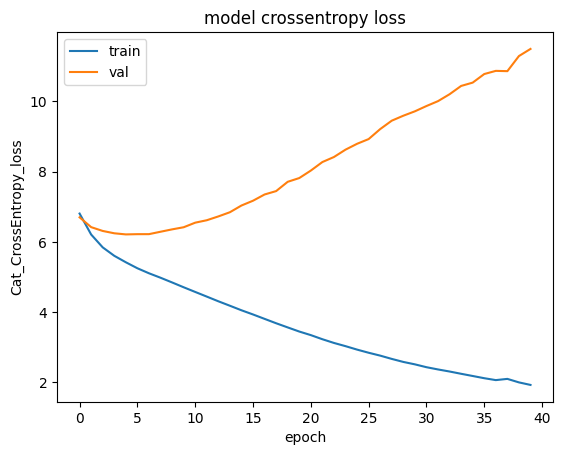

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model crossentropy loss')
plt.ylabel('Cat_CrossEntropy_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:

K.clear_session()
model = tf.keras.Sequential(
    [tf.keras.layers.Embedding(input_dim = total_unique_words, 
                               output_dim=100, weights=[embeddings_matrix], 
                               input_length=max_seq_length-1, 
                               trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(total_unique_words , activation='softmax')])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 100)           729900    
                                                                 
 bidirectional (Bidirectiona  (None, 11, 512)          731136    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

In [40]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', patience=3)
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=256, callbacks=[es])

Epoch 1/100
221/221 [==============================] - 10s 28ms/step - loss: 6.8040 - accuracy: 0.0488 - val_loss: 6.7193 - val_accuracy: 0.0620
Epoch 2/100
221/221 [==============================] - 5s 23ms/step - loss: 6.2250 - accuracy: 0.0798 - val_loss: 6.4077 - val_accuracy: 0.0951
Epoch 3/100
221/221 [==============================] - 5s 23ms/step - loss: 5.8327 - accuracy: 0.1071 - val_loss: 6.2779 - val_accuracy: 0.1067
Epoch 4/100
221/221 [==============================] - 5s 23ms/step - loss: 5.5840 - accuracy: 0.1196 - val_loss: 6.2351 - val_accuracy: 0.1090
Epoch 5/100
221/221 [==============================] - 5s 23ms/step - loss: 5.4028 - accuracy: 0.1256 - val_loss: 6.1820 - val_accuracy: 0.1165
Epoch 6/100
221/221 [==============================] - 5s 23ms/step - loss: 5.2385 - accuracy: 0.1314 - val_loss: 6.1990 - val_accuracy: 0.1179
Epoch 7/100
221/221 [==============================] - 5s 23ms/step - loss: 5.1018 - accuracy: 0.1374 - val_loss: 6.1955 - val_accuracy

In [41]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)
#https://stackoverflow.com/questions/41881308/how-to-calculate-perplexity-of-rnn-in-tensorflow/42025194#42025194
print(f'perplexity = {np.exp(results[0])} vs 7299 unique words')

Evaluate on test data
5/5 [==============================] - 0s 8ms/step - loss: 5.3297 - accuracy: 0.1689
test loss, test acc: [5.329738616943359, 0.1689189225435257]
perplexity = 206.38402181903714 vs 7299 unique words


Perplexity of 206 vs 7300 vocabulary size is better than what the accuracy implies.

If we are using this for a smartphone next word prediction we would suggest multiple next words, in this case lets assume thats 5 and see how the system performs via accuracy of whether the highest probability 5 words predicted by the model match the actual test word.

In [114]:
i=0
temp = tf.math.top_k(model.predict(x_test, verbose=1), k =5)[1]
previous_text =  [''.join([list(word_index.keys())[list(word_index.values()).index(j)]+" " if j !=0 else ''  for j in list(i)]) for i in  x_test]
predicted_words = [ [list(word_index.keys())[list(word_index.values()).index(i)]  for i in row] for row in temp]
actual_words = [ list(word_index.keys())[list(word_index.values()).index(i)] for i in  np.argmax(y_test, axis=-1)]
correctCount = 0
for predictionWord in predicted_words  :
    # print(predictionWord)
    # predicted = np.argmax(model.predict(seq, verbose=1), axis=-1)  
    # ouput_word = ""  
    # for word, index in tokenizer.word_index.items():
    #     if index == predicted:
    #         output_word = word
    #         break
    # if predictionWord == actual_words[i]: 
    # print(f'seed text: "{previous_text[i]}" pred: {predictionWord} act: {actual_words[i]}')
    if actual_words[i] in predictionWord:
        correctCount +=1
    
    i+=1
print(f'first 5 test accuracy {correctCount/len(actual_words)}' )
with open("data/test_sentences.pkl", "wb") as fp:   
    pickle.dump(previous_text, fp) 
with open("data/test_nextWord.pkl", "wb") as fp:   
    pickle.dump(actual_words, fp) 

19/19 [==============================] - 0s 25ms/step
first 5 test accuracy 0.3125


In [113]:
i=0
temp = tf.math.top_k(model.predict(x_test[:20] , verbose=1), k =5)[1]
previous_text =  [''.join([list(word_index.keys())[list(word_index.values()).index(j)]+" " if j !=0 else ''  for j in list(i)]) for i in  x_test[:20] ]
predicted_words = [ [list(word_index.keys())[list(word_index.values()).index(i)]  for i in row] for row in temp]
actual_words = [ list(word_index.keys())[list(word_index.values()).index(i)] for i in  np.argmax(y_test, axis=-1)]
for predictionWord in predicted_words :
    # print(predictionWord)
    # predicted = np.argmax(model.predict(seq, verbose=1), axis=-1)  
    # ouput_word = ""  
    # for word, index in tokenizer.word_index.items():
    #     if index == predicted:
    #         output_word = word
    #         break
    # if predictionWord == actual_words[i]: 
    print(f'seed text: "{previous_text[i]}" pred: {predictionWord} act: {actual_words[i]}')
    i+=1
import pickle
with open("data/test_sentences.pkl", "wb") as fp:   
    pickle.dump(previous_text, fp) 
with open("data/test_nextWord.pkl", "wb") as fp:   
    pickle.dump(actual_words, fp) 



1/1 [==============================] - 0s 25ms/step
seed text: "what's " pred: ['a', 'going', 'not', 'you', 'better'] act: my
seed text: "what's my " pred: ['friend', 'work', 'eyes', 'surprise', 'shoes'] act: book
seed text: "what's my book " pred: ['is', 'was', 'has', 'will', 'are'] act: doing
seed text: "what's my book doing " pred: ['to', 'a', 'the', 'up', 'it'] act: here
seed text: "what " pred: ['you', 'do', 'is', 'did', 'are'] act: an
seed text: "what an " pred: ['you', 'the', 'a', 'your', 'of'] act: ambiguous
seed text: "what an ambiguous " pred: ['is', 'of', 'you', 'that', 'to'] act: expression
seed text: "i'm " pred: ['a', 'going', 'not', 'you', 'better'] act: sort
seed text: "i'm sort " pred: ['to', 'that', 'of', 'for', 'much'] act: of
seed text: "i'm sort of " pred: ['you', 'the', 'your', 'a', 'school'] act: tired
seed text: "we'll " pred: ['a', 'going', 'not', 'you', 'better'] act: what
seed text: "give " pred: ['you', 'me', 'your', 'the', 'him'] act: me
seed text: "give me

Upon review it seems to perform best in predicting very common words such as is, the, a and pronouns and doesn't do well on predicting less common verbs and more specific nouns.

Save the model for use in separate py files

In [44]:
model.save('model\LSTMWordList.keras')


## Test the final predictor package

In [4]:
from next_word_pred import predict 
predictor = predict.LSTM_next_word_pred()
print(predictor.predict("where"))

print(predictor.predict("")  )
print(predictor.predict("I'll call them"))

print(predictor.predict("I just don't know"))


1/1 [==============================] - 1s 743ms/step
['are', 'do', 'you', 'is', 'will']
1/1 [==============================] - 0s 14ms/step
['a', 'going', 'not', 'you', 'better']
1/1 [==============================] - 0s 14ms/step
['to', 'you', 'your', 'a', 'the']
1/1 [==============================] - 0s 16ms/step
['you', 'i', 'what', 'that', 'how']
